![pytorch flow](https://cdn-images-1.medium.com/max/800/1*uZrS4KjAuSJQIJPgOiaJUg.png)

### Load Files

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from PIL import Image
 

import os
print(os.listdir("../input"))


['cifar10']


In [3]:
run_model1 = False
run_model2 = True

In [4]:
def load_cifar10_data(filename):
    with open('../input/cifar10/'+ filename, 'rb') as file:
        batch = pickle.load(file, encoding='latin1')

    features = batch['data']
    labels = batch['labels']
    return features, labels

In [5]:
# Load files
batch_1, labels_1 = load_cifar10_data('data_batch_1')
batch_2, labels_2 = load_cifar10_data('data_batch_2')
batch_3, labels_3 = load_cifar10_data('data_batch_3')
batch_4, labels_4 = load_cifar10_data('data_batch_4')
batch_5, labels_5 = load_cifar10_data('data_batch_5')

test, label_test = load_cifar10_data('test_batch')

FileNotFoundError: [Errno 2] No such file or directory: '../data/cifar10/data_batch_1'

In [5]:
# Merge files
X_train = np.concatenate([batch_1,batch_2,batch_3,batch_4,batch_5], 0)
Y_train = np.concatenate([labels_1,labels_2,labels_3,labels_4,labels_5], 0)


In [6]:
classes = ('airplane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def return_photo(batch_file):
    assert batch_file.shape[1] == 3072
    dim = np.sqrt(1024).astype(int)
    r = batch_file[:, 0:1024].reshape(batch_file.shape[0], dim, dim, 1)
    g = batch_file[:, 1024:2048].reshape(batch_file.shape[0], dim, dim, 1)
    b = batch_file[:, 2048:3072].reshape(batch_file.shape[0], dim, dim, 1)
    photo = np.concatenate([r,g,b], -1)
    return photo




In [7]:
X_train = return_photo(X_train)
X_test = return_photo(test)
Y_test = np.array(label_test)

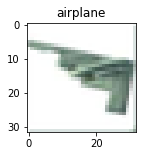

In [8]:
def plot_image(number, file, label, pred=None):
    fig = plt.figure(figsize = (3,2))
    #img = return_photo(batch_file)
    plt.imshow(file[number])
    if pred is None:
        plt.title(classes[label[number]])
    else:
        plt.title('Label_true: ' + classes[label[number]] + '\nLabel_pred: ' + classes[pred[number]])
    
plot_image(12345, X_train, Y_train)

0    5000
1    5000
2    5000
3    5000
4    5000
5    5000
6    5000
7    5000
8    5000
9    5000
dtype: int64


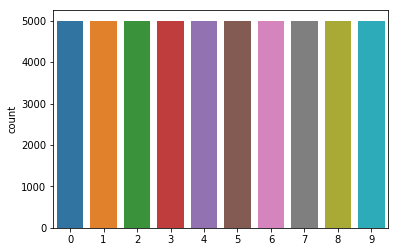

In [9]:
# The cifar-10 is designed to balance distribution that the counts for each classification are 5000
import seaborn as sns
sns.countplot(Y_train)
hist_Y_train = pd.Series(Y_train).groupby(Y_train).count()
print(hist_Y_train)

### Preprocessing

In [10]:
### 若使用 CrossEntropyLoss為Loss function, 則不需在輸入前將標籤手動轉換成one-hot格式
#
#from sklearn import preprocessing
#oh_encoder = preprocessing.OneHotEncoder(categories='auto')
#oh_encoder.fit(Y_train.reshape(-1,1))

### In pytorch we dont need to normalize here, the 'transform' will do it for us.
#
#X_train_nor = X_train.astype('float32') / 255.0
#X_test_nor = X_test.astype('float32') / 255.0


#Y_train_oh = oh_encoder.transform(Y_train.reshape(-1,1)).toarray()
#Y_test_oh = oh_encoder.transform(Y_test.reshape(-1,1)).toarray()

# print('One-hot:')
# print(Y_train_oh[:5])
# print('\nLabel:')
# print(Y_train[:5])

In [11]:
# Final check for dimensions before pre-pocessing
print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)
print('X_test shape:', X_test.shape)
print('Y_test shape:', Y_test.shape)

X_train shape: (50000, 32, 32, 3)
Y_train shape: (50000,)
X_test shape: (10000, 32, 32, 3)
Y_test shape: (10000,)


In [12]:
# split the validation set out
from sklearn.model_selection import train_test_split
X_train_split, X_val_split, Y_train_split, Y_val_split = train_test_split(
    X_train, Y_train, test_size=0.2, random_state=42)

In [13]:
### 自定義Dataset: 
### Prepare for training & testing dataset. Define dataset class.
import torch
import torchvision.transforms as transforms
import random
from torch.utils.data import Dataset
from PIL import Image

# define the random seed for reproducible result
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)


# 繼承自Dataset物件
class CIFAR10_from_array(Dataset): 
    def __init__(self, data, label, transform=None):
        ##############################################
        ### Initialize paths, transforms, and so on
        ##############################################
        #self.data = torch.from_numpy(data).float()
        #self.label = torch.from_numpy(label).long()
        self.data = data
        self.label = label
        self.transform = transform
        self.img_shape = data.shape
        
    def __getitem__(self, index):
        ##############################################
        # 1. Read from file (using numpy.fromfile, PIL.Image.open)
        # 2. Preprocess the data (torchvision.Transform).
        # 3. Return the data (e.g. image and label)
        ##############################################
        
        img = Image.fromarray(self.data[index])
        label = self.label[index]
        if self.transform is not None:
            img = self.transform(img)
        else:
            img_to_tensor = transforms.ToTensor()
            img = img_to_tensor(img)
            #label = torch.from_numpy(label).long()
        return img, label
        
    def __len__(self):
        ##############################################
        ### Indicate the total size of the dataset
        ##############################################
        return len(self.data)
    
    def plot_image(self, number):
        file = self.data
        label = self.label
        fig = plt.figure(figsize = (3,2))
        #img = return_photo(batch_file)
        plt.imshow(file[number])
        plt.title(classes[label[number]])
        
        


In [14]:
class CIFAR10_from_url(Dataset): 
    pass

In [15]:
# Normalize for R, G, B with img = img - mean / std
def normalize_dataset(data):
    mean = data.mean(axis=(0,1,2)) / 255.0
    std = data.std(axis=(0,1,2)) / 255.0
    normalize = transforms.Normalize(mean=mean, std=std)
    return normalize


# apply transforms to return img as tensor type
# ToTensor: 函数接受PIL Image或numpy.ndarray，将其先由HWC转置为CHW格式，再转为float后每个像素除以255.
# Notice that the order in the "compose" does matter
train_transform_aug = transforms.Compose([
    transforms.Resize((40, 40)),       #先調整至略大的影像，
    transforms.RandomCrop((32, 32)),   #再隨機擷取至模型輸入之大小，是常用的影像增量技巧之一。
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    normalize_dataset(X_train)
])

# Also use X_train in normalize since train/val sets should have same distribution
val_transform = transforms.Compose([
    transforms.ToTensor(),
    normalize_dataset(X_train)
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    normalize_dataset(X_test)
])

trainset = CIFAR10_from_array(data=X_train_split, label=Y_train_split, transform=train_transform_aug)
valset = CIFAR10_from_array(data=X_val_split, label=Y_val_split, transform=val_transform)
testset = CIFAR10_from_array(data=X_test, label=Y_test, transform=test_transform)

In [16]:
print('data shape check')
print('training set:'.ljust(20) + '{}'.format(trainset.img_shape))
print('validation set:'.ljust(20) + '{}'.format(valset.img_shape))
print('testing set:'.ljust(20) + '{}'.format(testset.img_shape))
print('label numbers:'.ljust(20) + '{}'.format(len(set(trainset.label))))

data shape check
training set:       (40000, 32, 32, 3)
validation set:     (10000, 32, 32, 3)
testing set:        (10000, 32, 32, 3)
label numbers:      10


In [17]:
# put into the data loader
from torch.utils.data import DataLoader

batch_size = 64
num_workers = 1

train_loader = DataLoader(dataset=trainset,
                          batch_size=batch_size, 
                          shuffle=True,
                          num_workers=num_workers)


val_loader = DataLoader(dataset=valset,
                          batch_size=batch_size, 
                          shuffle=False,
                          num_workers=num_workers)

test_loader = DataLoader(dataset=testset,
                          batch_size=batch_size, 
                          shuffle=False,
                          num_workers=num_workers)

In [18]:
imgs, lbls = iter(train_loader).next()
print ('Size of image:', imgs.size())  # batch_size*3*224*224
print ('Type of image:', imgs.dtype)   # float32
print ('Size of label:', lbls.size())  # batch_size
print ('Type of label:', lbls.dtype)   # int64(long)

### Or you can do this:
#for imgs, lbls in train_loader:
#    print ('Size of image:', imgs.size())  # batch_size*3*224*224
#    print ('Type of image:', imgs.dtype)   # float32
#    print ('Size of label:', lbls.size())  # batch_size
#    print ('Type of label:', lbls.dtype)   # int64(long)
#    break



Size of image: torch.Size([64, 3, 32, 32])
Type of image: torch.float32
Size of label: torch.Size([64])
Type of label: torch.int64


### Build Model

### Model with out augmentation

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.utils.data as Data
import torchvision.transforms as transforms

In [20]:
# Build the CNN
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=(2,2), stride=2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
            

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        
        ### view 等同 reshape. 差別在於pytorch中reshape是複製, 而view則是永遠指向源頭
        # "Unlike reshape, reshape always copies memory. view never copies memory."
        #ref: z = torch.zeros(3, 2)
        #>>>  x = z.view(2, 3)
        #>>>  z.fill_(1)
        #>>>  x
        #    tensor([[1., 1., 1.],
        #            [1., 1., 1.]]) 
        
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

#display net architecture
print(Net())



Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [21]:
import torch.optim as optim
import time

def update_info(idx, length, epoch_loss, acc, mode):
    
    if length >= 250:
        update_size = int(length/250)
    else:
        update_size = 5
    
    if idx % update_size == 0 and idx != 0:
        #print ('=', end="")        
        finish_rate = idx/length * 100
        print ("\r   {} progress: {:.2f}%  ......  loss: {:.4f} , acc: {:.4f}".
               format(mode, finish_rate, epoch_loss/idx, acc), end="", flush=True)
        

def val_per_epoch(model, loss_fn, dataloader, verbose):
    # In validation, we only compute loss value
    model.eval()
    epoch_loss = 0.0
    acc = 0.0
    val_size = 0
    with torch.no_grad(): 
        for i, (feature, target) in enumerate(dataloader):
            
            #feature, target = feature.to(device), target.to(device)
            if torch.cuda.is_available():
                feature = feature.cuda()
                target = target.cuda()
            
            output = model(feature) #outputs.data.shape= batches_num * num_class
            
            #compute acc
            _, pred = torch.max(output.data, dim=1) 
            correct = (pred == target).sum().item() #convert to number
            val_size += target.size(0)
            acc += correct
            
            
            loss = loss_fn(output, target)
            epoch_loss += loss.item()
            
            
            idx = i
            length = len(dataloader)
            
            #display progress
            if verbose:
                update_info(idx, length, epoch_loss, acc/val_size, 'validating')
                
        acc = acc/val_size
    print('')
    return epoch_loss/len(dataloader), acc


def train_per_epoch(model, loss_fn, dataloader, optimizer, verbose): 
    #train mode
    model.train()
    
    #initialize loss
    epoch_loss = 0.0
    acc = 0.0
    train_size = 0
    
    for i, (feature, target) in enumerate(dataloader):
        #feature, target = feature.to(device), target.to(device)
        
        if torch.cuda.is_available():
            feature = feature.cuda()
            target = target.cuda()
        
        #set zero to the parameter gradients for initialization
        optimizer.zero_grad()
        output = model(feature)
        loss = loss_fn(output, target)
        
        
        #compute acc
        _, pred = torch.max(output.data, dim=1) 
        correct = (pred == target).sum().item() #convert to number
        train_size += target.size(0)
        acc += correct
        
        #compute current loss. Loss is a 0-dim tensor, so use tensor.item() to get the scalar value
        epoch_loss += loss.item()  
        
        #backward propagation
        loss.backward()
        
        #this represents one update on the weight/bias for a mini-batch(16 images in our case): 
        #weights[k] + alpha * d_weights[k]
        optimizer.step()
        
        #show the update information
        idx = i
        length = len(dataloader)
        
        #display progress
        if verbose:
            update_info(idx, length, epoch_loss, acc/train_size, '  training')
            
    acc = acc/train_size
    print('') 
    return epoch_loss/len(dataloader), acc



"""
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, train_loss / 2000))
                running_loss = 0.0

    print('Finished Training')
"""


def model_training(num_epochs, model, loss_fn, train_loader, optimizer, val_loader=None, verbose=True):
    
    train_batch_num = len(train_loader)
    history = {}
    history['train_loss'] = []
    history['val_loss'] = []
    history['train_acc'] = []
    history['val_acc'] = []
    
    if val_loader is not None:
        
        val_batch_num = len(val_loader)
        
        print('Total Sample: Train on {} samples, validate on {} samples.'.
             format(trainset.img_shape[0], valset.img_shape[0]))
        
        print(' Total Batch: Train on {} batches, validate on {} batches. {} samples/minibatch \n'.
         format(train_batch_num, val_batch_num, batch_size))
    
    else:
        print('Total Sample: Train on {} samples.'.
             format(train_batch_num*batch_size))
        
        print(' Total Batch: Train on {} batches, {} samples/minibatch \n'.
         format(train_batch_num, batch_size))
    
    
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        train_loss, train_acc = train_per_epoch(model, loss_fn, train_loader, optimizer, verbose=verbose)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        
        
        if val_loader is not None:
            val_loss, val_acc = val_per_epoch(model, loss_fn, val_loader, verbose=verbose)
            print('\n        Training Loss: {:.4f}, Validation Loss: {:.4f}'.format(train_loss,val_loss))
            print('         Training acc: {:.4f},  Validation acc: {:.4f}\n'.format(train_acc,val_acc))
            history['val_loss'].append(val_loss)
            history['val_acc'].append(val_acc)
                        
        else:
            print('\n        Training Loss: {:.4f}\n'.format(train_loss))
            print('\n         Training acc: {:.4f}\n'.format(train_acc))
        
    
    return history

In [22]:
# Training/Validating the model
classes = ('airplane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

#若需要設置學習率衰減, 在外部定義管理函數 再灌到optimzer內輸入
def lr_decay(parm):
    pass

if __name__ == '__main__' and run_model1 == True:

    num_epochs = 10
    learning_rate = 0.001

    net = Net()

    if torch.cuda.is_available():
        net = net.cuda()
    print(net)
    print('=================================================================')

    #若使用 CrossEntropyLoss為Loss function, 則不應在網路的最後一層添加softmax
    criterion = nn.CrossEntropyLoss() #loss function
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    #training and validating
    hist1 = model_training(num_epochs, net, criterion, train_loader, optimizer, val_loader, verbose=True)


In [23]:
def imshow(img):
    img = img    # unnormalize
    #print(img)
    npimg = img.numpy()
    print(np.transpose(npimg, (1, 2, 0)).shape)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

if __name__ == '__main__' and run_model1 == True:
    dataiter = iter(test_loader)
    images, labels = dataiter.next()

    # print images
    #imshow(torchvision.utils.make_grid(images))
    #print(labels[0])
    #print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(5)))

    for i in range(len(images)):
        plot_image(i, images.permute(0, 2, 3, 1).numpy(), labels.numpy())


    if torch.cuda.is_available():
        images = images.cuda()
    outputs = net(images)

    _, predicted = torch.max(outputs, 1)

    print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                                  for j in range(5)))

### Model with dropout

In [24]:
# Build the CNN
class Net_dropout(nn.Module):
    def __init__(self, dropout=0.2):
        super(Net_dropout, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, stride=1, padding=2)
        #3*32*32 -> 32*32*32
        self.dropout1 = nn.Dropout(p=dropout)        
        self.pool1 = nn.MaxPool2d(kernel_size=(2,2), stride=2)
        #32*32*32 -> 16*16*32
        self.conv2 = nn.Conv2d(32, 64, 3, stride=1, padding=1)
        #16*16*32 -> 16*16*64
        self.dropout2 = nn.Dropout(p=dropout)
        self.pool2 = nn.MaxPool2d(kernel_size=(2,2), stride=2)
        #16*16*64 -> 8*8*64
        self.fc1 = nn.Linear(8*8*64, 1024)
        self.dropout3 = nn.Dropout(p=dropout)
        self.fc2 = nn.Linear(1024, 512)
        self.dropout4 = nn.Dropout(p=dropout)
        self.fc3 = nn.Linear(512, 10)
            

    def forward(self, x):
        x = self.dropout1(self.conv1(x))
        x = self.pool1(F.relu(x))
        x = self.dropout2(self.conv2(x))
        x = self.pool2(F.relu(x))
        x = x.view(-1, self.num_flat_features(x)) 
        #self.num_flat_features(x) = 8*8*64 here.
        #-1 means: get the rest a row (in this case is 16 mini-batches)
        #pytorch nn only takes mini-batch as the input
        
        x = F.relu(self.fc1(x))
        x = self.dropout3(x)
        x = F.relu(self.fc2(x))
        x = self.dropout4(x)
        x = self.fc3(x)
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:] # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


        
#display net architecture
print(Net_dropout())  

###
# Keras structure
#def build_basic_net(model, dropout=0.2):
#    model.add(Conv2D(filters=32, kernel_size=(5,5), padding='same', strides=1,
#                     input_shape=X_train.shape[1:], activation='relu'))
#    model.add(Dropout(dropout))
#    model.add(MaxPooling2D(pool_size=(2, 2)))
#    model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', strides=1,
#                     input_shape=X_train.shape[1:], activation='relu'))
#    model.add(Dropout(dropout))
#    model.add(MaxPooling2D(pool_size=(2, 2)))
#    
#    model.add(Flatten())
#    model.add(Dense(1024, activation='relu'))
#    model.add(Dropout(dropout))
#    model.add(Dense(512, activation='relu'))
#    model.add(Dropout(dropout))
#    model.add(Dense(10,activation='softmax'))

Net_dropout(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (dropout1): Dropout(p=0.2)
  (pool1): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dropout2): Dropout(p=0.2)
  (pool2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4096, out_features=1024, bias=True)
  (dropout3): Dropout(p=0.2)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (dropout4): Dropout(p=0.2)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
)


In [25]:
if __name__ == '__main__' and run_model2 == True:

    num_epochs = 10
    learning_rate = 0.001

    net = Net_dropout(0.2)

    if torch.cuda.is_available():
        net = net.cuda()
    print(net)
    print('=================================================================')

    #若使用 CrossEntropyLoss為Loss function, 則不應在網路的最後一層添加softmax
    criterion = nn.CrossEntropyLoss() #loss function
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)

    #training and validating
    hist2 = model_training(num_epochs, net, criterion, train_loader, optimizer, val_loader, verbose=True)

Net_dropout(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (dropout1): Dropout(p=0.2)
  (pool1): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dropout2): Dropout(p=0.2)
  (pool2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4096, out_features=1024, bias=True)
  (dropout3): Dropout(p=0.2)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (dropout4): Dropout(p=0.2)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
)
Total Sample: Train on 40000 samples, validate on 10000 samples.
 Total Batch: Train on 625 batches, validate on 157 batches. 64 samples/minibatch 

Epoch 1/10
     training progress: 99.84%  ......  loss: 1.6319 , acc: 0.4064
   validating progress: 98.73%  ......  loss: 1.3440 , acc: 0.5323

        Training Loss: 1.6293, Validation Loss: 1.3

### Model Testing

In [26]:
def model_testing(model, loss_fn, dataloader, verbose=True):
    Y_pred = []
    correct = 0
    total = 0
    epoch_loss = 0.0
    acc = 0.0
    test_size = 0
    with torch.no_grad():
        for i, (feature, target) in enumerate(dataloader):
            if torch.cuda.is_available():
                feature = feature.cuda()
                target = target.cuda()

            outputs = model(feature)  #outputs.data.shape= batches_num * num_class
            
            #compute acc
            _, pred = torch.max(outputs.data, 1)
            correct = (pred == target).sum().item() #convert to number
            test_size += target.size(0)
            #print(test_size)
            acc += correct
            
            loss = loss_fn(outputs, target)
            epoch_loss += loss.item()
            
            idx = i
            length = len(dataloader)


            #if torch.cuda.is_available():
            #    pred = pred.cuda()
            
            #Pred labels 
            Y_pred += pred.cpu().numpy().tolist()
            
            if verbose:
                update_info(idx, length, epoch_loss, acc/test_size, 'testing')    
            
    acc = acc/test_size
    print('\n\n Accuracy of the network on the {} test images: {}%'.format(test_size, 100*acc))
    
    return Y_pred




if __name__ == '__main__' and run_model1 == True:
    Y_pred1 = model_testing(net, criterion, test_loader, True)
    
if __name__ == '__main__' and run_model2 == True:
    Y_pred2 = model_testing(net, criterion, test_loader, True)

   testing progress: 98.73%  ......  loss: 0.9443 , acc: 0.6770

 Accuracy of the network on the 10000 test images: 67.71000000000001%


In [27]:
# Plot the loss and accuracy curves for training and validation 
def loss_acc_plt(history):
    fig, ax = plt.subplots(2,1)
    ax[0].plot(history['train_loss'], color='b', label="Training loss")
    ax[0].plot(history['val_loss'], color='r', label="validation loss",axes =ax[0])
    legend = ax[0].legend(loc='best', shadow=True)

    ax[1].plot(history['train_acc'], color='b', label="Training accuracy")
    ax[1].plot(history['val_acc'], color='r',label="Validation accuracy")
    legend = ax[1].legend(loc='best', shadow=True)
    

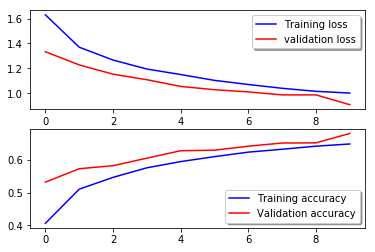

In [28]:
if __name__ == '__main__' and run_model1 == True:
    loss_acc_plt(hist1)
    
if __name__ == '__main__' and run_model2 == True:
    loss_acc_plt(hist2)


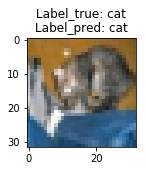

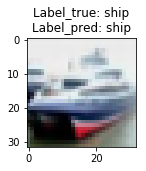

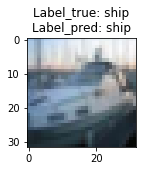

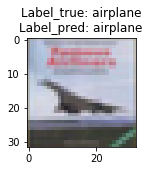

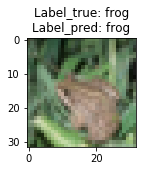

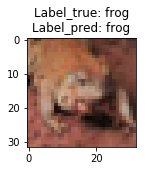

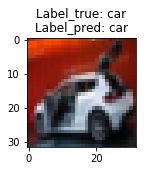

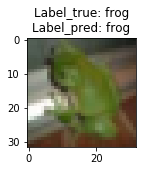

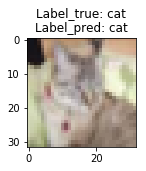

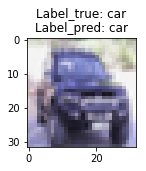

In [29]:
if __name__ == '__main__' and run_model1 == True:
    for i in range(10):
        plot_image(i, test_loader.dataset.data, test_loader.dataset.label, Y_pred1)
    
if __name__ == '__main__' and run_model2 == True:
    for i in range(10):
        plot_image(i, test_loader.dataset.data, test_loader.dataset.label, Y_pred2)



### Confusion Matrix

In [30]:
from sklearn.metrics import confusion_matrix


if __name__ == '__main__' and run_model1 == True:
    cm = confusion_matrix(Y_test, Y_pred1)
    
    
if __name__ == '__main__' and run_model2 == True:
    cm = confusion_matrix(Y_test, Y_pred2)

cm

array([[806,  28,  52,  12,  16,   1,   9,   7,  43,  26],
       [ 47, 832,   4,   4,   1,   0,  18,   1,  15,  78],
       [ 95,   8, 474,  47, 146,  33, 131,  34,  10,  22],
       [ 31,  18,  55, 478,  85,  90, 144,  45,  19,  35],
       [ 43,   4,  37,  37, 686,   5, 115,  64,   5,   4],
       [ 24,   6,  36, 181,  92, 443,  96,  87,  12,  23],
       [ 12,   3,  28,  39,  25,   6, 873,   4,   6,   4],
       [ 45,  12,  18,  30,  87,  20,  23, 732,   5,  28],
       [137,  43,   9,   9,  13,   0,   8,   2, 752,  27],
       [ 81, 164,   5,  11,   4,   1,  12,  11,  16, 695]])

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

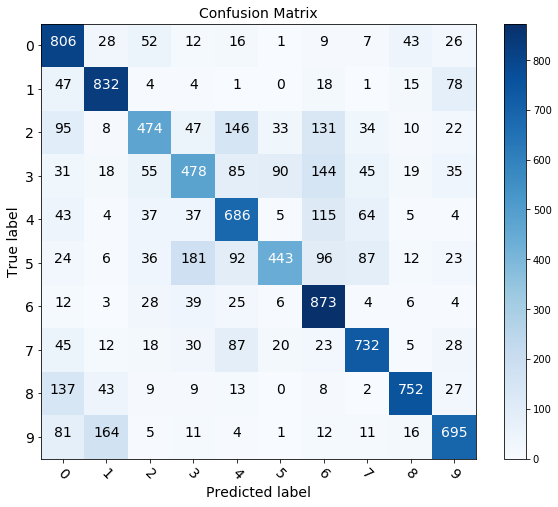

In [31]:
plt.figure(figsize = (10,8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

plt.title('Confusion Matrix', fontsize=14)
plt.colorbar()
n_classes = cm.shape[0]
range_class = range(n_classes)
tick_marks = np.arange(len(range_class))
plt.xticks(tick_marks, range_class, rotation=-45, fontsize=14)
plt.yticks(tick_marks, range_class, fontsize=14)
plt.xlabel('Predicted label', fontsize=14)
plt.ylabel('True label', fontsize=14)

for i in range_class:
    for j in range_class:        
        plt.text(j, i, cm[i,j], horizontalalignment="center", fontsize=14, 
                color="white" if i==j else "black")
plt.plot

In [32]:
for i in range(len(classes)):
    correct = ((Y_test == i)*1) * ((np.array(Y_pred2) == Y_test)*1)
    print('{}, {}: '.rjust(10).format(i, classes[i]) + '{}%'.
          format(100*correct.sum()/Y_test[Y_test == i].shape[0]))

  0, airplane: 80.6%
  1, car: 83.2%
  2, bird: 47.4%
  3, cat: 47.8%
  4, deer: 68.6%
  5, dog: 44.3%
  6, frog: 87.3%
  7, horse: 73.2%
  8, ship: 75.2%
  9, truck: 69.5%


### Kaggle Submission

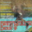

In [33]:
import zipfile, os
kaggle_test_file_path = "../input/cifar10-object-recognition-in-images-zip-file/train_test/test.zip"
zipFile = zipfile.ZipFile(kaggle_test_file_path)

zipFile_img = zipFile.open('test/1.png')
Image.open(zipFile_img)

In [34]:
#The order of the filename in ZIP info needs to be sorted first, that's why I use re here.
import re

# make train & test dataset
class Cifar10_kaggle_test(Dataset):
    def __init__(self, file_url):
        self.file_url = file_url
        self.img_size = 0
        self.len = 0
        
        with zipfile.ZipFile(self.file_url) as archive:
            self.infolist = archive.infolist()
            
            for i, entry in enumerate(self.infolist):
                img_idx = int(re.split(r'[/.]', entry.filename)[1])
                with archive.open(entry) as file:
                    img = Image.open(file)
                    
                    
                    #def images array
                    if i == 0:
                        self.img_size = img.size
                        self.len = len(self.infolist)
                        images = np.zeros((self.len, self.img_size[0], self.img_size[1], 3))
                        img_indices = np.zeros((self.len))
                    img_array = np.asarray(img)
                    images[i] = img_array
                    img_indices[i] = img_idx
                    
                    #print("\r loading ... {} / {}".format(i, self.len), end="")
        #print('\n Done!')            
        self.images = images.astype('uint8')
        self.img_indices = img_indices.astype('int64')
        del img, img_array

    def __len__(self):
        return self.len

    def __getitem__(self, index):
        img = Image.fromarray(self.images[index])
        img_to_tensor = transforms.ToTensor()
        img = img_to_tensor(img)
        return img
    
kaggle_test_url = "../input/cifar10-object-recognition-in-images-zip-file/train_test/test.zip"
kaggle_test = Cifar10_kaggle_test(kaggle_test_url)

In [35]:
print(kaggle_test[0].shape)

batch_size=64
num_workers=1
kaggle_test_loader = DataLoader(dataset=kaggle_test,
                                batch_size=batch_size, 
                                shuffle=False,
                                num_workers=num_workers)

torch.Size([3, 32, 32])


In [36]:
def kaggle_model_testing(model, dataloader, verbose=True):
    Y_pred = []
    #correct = 0
    #total = 0
    #epoch_loss = 0.0
    #acc = 0.0
    test_size = 0
    with torch.no_grad():
        for i, feature in enumerate(dataloader):
            if torch.cuda.is_available():
                feature = feature.cuda()
                #target = target.cuda()

            outputs = model(feature)  #outputs.data.shape= batches_num * num_class
            
            #compute acc
            _, pred = torch.max(outputs.data, 1)
            #correct = (pred == target).sum().item() #convert to number
            test_size += feature.size(0)
            #print(test_size)
            #acc += correct
            
            #loss = loss_fn(outputs, target)
            #epoch_loss += loss.item()
            
            idx = i
            length = len(dataloader)


            #if torch.cuda.is_available():
            #    pred = pred.cuda()
            
            #Pred labels 
            Y_pred += pred.cpu().numpy().tolist()
            
            if verbose:
                #update_info(idx, length, epoch_loss, acc/test_size, 'testing')
                print('\r Now predicting on the {}/{} batch...'.format(idx,length), end='')
            
    #acc = acc/test_size
    print('\n Done!')
    
    return Y_pred


In [37]:
Y_pred_kaggle = kaggle_model_testing(net, kaggle_test_loader)

print(len(Y_pred_kaggle))

 Now predicting on the 4687/4688 batch...
 Done!
300000


In [38]:
kaggle_test_df = (pd.DataFrame({'label':Y_pred_kaggle}).applymap(lambda x:classes[x]))
kaggle_test_df.insert(0, "id", kaggle_test.img_indices.astype('int64'))
kaggle_test_df = kaggle_test_df.sort_values(by='id', ascending=True)

#pd.DataFrame({"ImageId": list(range(1,len(preds)+1)), "Label": preds})

In [39]:
kaggle_test_df.to_csv("cifar10_kaggle_pytorch.csv", index=False, header=True)
